In [59]:
import torch
import torch.utils.data
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from tqdm import tqdm 
import pickle
import time
import matplotlib.pyplot as plt

In [2]:
from tdnn import TDNN

In [3]:
import torch.nn.functional as F
from torch.autograd import Variable
import math


class StatsPooling(nn.Module):
    def __init__(self):
        super(StatsPooling,self).__init__()

    def forward(self,varient_length_tensor):
        mean = varient_length_tensor.mean(dim=2)
        std = varient_length_tensor.std(dim=2)
        return torch.cat((mean,std),dim=1)



 ## Data preperation

In [4]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [5]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [6]:
clases = ['Trump','Macron','Gaga','Clinton']

In [7]:
# X = []
# y = []
# max_total_context = 400
# _min,_max = float('inf'),-float('inf')

# for wav_name in os.listdir('train_cleaned'):
#     if wav_name.endswith('wav'):
#         print (wav_name)
#         rate, wav = wavfile.read(r'train_cleaned/'+wav_name)
#         for chunked_wav in tqdm(chunks(wav,int(len(wav)/4))):
#             X_sample = mfcc(chunked_wav,samplerate= rate,numcep=24
#                    ,nfilt=26,nfft=1024)
#             _min = min(np.amin(X_sample),_min)
#             _max = max(np.amax(X_sample),_max)
            
#             for chunked_X_sample in list(chunks(X_sample,max_total_context)):
#                 if len(chunked_X_sample) == max_total_context:
#                     X.append(chunked_X_sample)
#                     y.append(to_categorical(clases.index(wav_name.split('.wav')[0]),len(clases)))
#                 else:
#                     print ('discarded box')
# X = (X - _min) / (_max-_min)
# with open('X_data.pkl','wb') as f:
#     pickle.dump((X,y),f)

In [8]:
with open('X_data_16_06.pkl','rb') as f:
    X,y =  pickle.load(f)

(array([488.,   0.,   0., 500.,   0.,   0., 136.,   0.,   0., 496.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

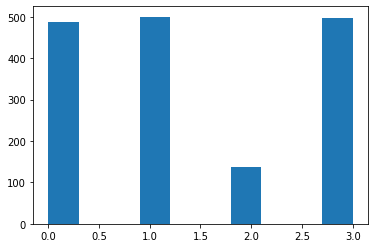

In [60]:
plt.hist(np.argmax(y,axis=1))

In [9]:

trainloader = torch.utils.data.DataLoader(list(zip(X,y)), shuffle=True, batch_size=50)

In [13]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
class StatsPooling(nn.Module):
    def __init__(self):
        super(StatsPooling,self).__init__()

    def forward(self,varient_length_tensor):
        mean = varient_length_tensor.mean(dim=2)
        std = varient_length_tensor.std(dim=2)
        return torch.cat((mean,std),dim=1)

class Xvector(nn.Module):
    def __init__(self):
        super(Xvector, self).__init__()
        context = [-2,2]
        input_dim = 24
        output_dim = 512
        self.net1 = TDNN(context, input_dim, output_dim, full_context=True)

        context = [-2,0,2]
        input_dim = 512
        output_dim = 512
        self.net2 = TDNN(context, input_dim, output_dim, full_context=False)

        context = [-3,0,3]
        input_dim = 512
        output_dim = 512
        self.net3 = TDNN(context, input_dim, output_dim, full_context=False)

        context = [0]
        input_dim = 512
        output_dim = 512
        self.net4 = TDNN(context, input_dim, output_dim, full_context=True)

        context = [0]
        input_dim = 512
        output_dim = 1500
        self.net5 = TDNN(context, input_dim, output_dim, full_context=True)

        self.SP = StatsPooling()
        self.hidden1 = nn.Linear(3000,512).double()
        self.hidden2 = nn.Linear(512,512).double()

        self.Final = nn.Linear(512,len(clases)).double()
        
    def forward(self,x):
        x = self.net1(x)
        x = self.net2(x)
        x = self.net3(x)
        x = self.net4(x)
        x = self.net5(x)
        x = self.SP(x).double()
        x = F.relu(self.hidden1(x))
        embedding = x 
        x = F.relu(self.hidden2(x))
        return self.Final(x) ,embedding
    

In [14]:
net = Xvector()

In [15]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
net = net.cuda()

In [ ]:
epocs = 300
for j in range (epocs):
    for i, data in enumerate(trainloader, 0):
        a = time.time()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.transpose(1,2).float()
        inputs, labels = inputs.cuda(), labels.cuda()
        output= net(inputs)[0].cuda()
        optimizer.zero_grad()
        loss = criterion(output, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        b = time.time()
    print ("loss: {} step took {}".format(loss,b-a))
    # print ("output:\n{} \n labels:\n{}".format(output,labels))
    # torch.save(net, 'total_model_batch_normed')


In [ ]:
  torch.save(net, 'model')


 ### Testing

In [17]:
xvec = torch.load('model')

In [18]:
xvec.eval()

Xvector(
  (net1): TDNN(
    (temporal_conv): Conv1d(24, 512, kernel_size=(5,), stride=(1,))
  )
  (net2): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
  )
  (net3): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
  )
  (net4): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  )
  (net5): TDNN(
    (temporal_conv): Conv1d(512, 1500, kernel_size=(1,), stride=(1,))
  )
  (SP): StatsPooling()
  (hidden1): Linear(in_features=3000, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=512, bias=True)
  (Final): Linear(in_features=512, out_features=4, bias=True)
)

In [19]:
xvec.cuda()

Xvector(
  (net1): TDNN(
    (temporal_conv): Conv1d(24, 512, kernel_size=(5,), stride=(1,))
  )
  (net2): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,))
  )
  (net3): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,))
  )
  (net4): TDNN(
    (temporal_conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  )
  (net5): TDNN(
    (temporal_conv): Conv1d(512, 1500, kernel_size=(1,), stride=(1,))
  )
  (SP): StatsPooling()
  (hidden1): Linear(in_features=3000, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=512, bias=True)
  (Final): Linear(in_features=512, out_features=4, bias=True)
)

In [56]:
wav_path = "train/Gaga.wav"
max_total_context_test = 400
_min,_max = float('inf'),-float('inf')
X_test = []
rate, wav = wavfile.read(wav_path)
for chunked_wav in tqdm(list(chunks(wav,int(len(wav)/400)))[:100]):
    X_sample = mfcc(chunked_wav,samplerate= rate,numcep=24
           ,nfilt=26,nfft=1024)
    _min = min(np.amin(X_sample),_min)
    _max = max(np.amax(X_sample),_max)
    for chunked_X_sample in list(chunks(X_sample,max_total_context_test)):
            if len(chunked_X_sample) == max_total_context_test:
                X_test.append(chunked_X_sample)
X_test = (X_test - _min) / (_max-_min)


/home/dan/anaconda2/envs/tf2_gpu/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
 58%|█████▊    | 58/100 [00:03<00:02, 18.13it/s]WARNING:root:frame length (1103) is greater than FFT size (1024), frame will be truncated. Increase NFFT to avoid.


100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


In [58]:
output= xvec(torch.tensor(X_test[80:100]).transpose(1,2).float().cuda())
for out in output[0]:
    print (clases[torch.argmax(out).cpu().numpy()])

Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
Gaga
